In [4]:
from google.colab import drive

drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [5]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import random
import matplotlib.pyplot as plt

In [6]:
# device : gpu를 사용할 경우에는 'cuda', 그렇지 않을 경우에는 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 랜덤 시드 고정.
# 실험 조건을 동일하게 설정하여,
# 같은 input을 넣으면 같은 결과가 나올 수 있도록 함.
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [7]:
batch_size = 128        # 배치크기
epochs = 15             # 학습 횟수
learning_rate = 0.001   # 학습률

In [8]:
train_dataset = datasets.MNIST(root='dataset/',     # 다운로드 경로 지정
                            train=True,             # True를 지정하면 훈련 데이터로 다운로드
                            download=True,
                            transform=transforms.Compose([transforms.ToTensor(),  # 텐서로 변환
                                                        transforms.Normalize(mean=(0.5,),std=(0.5,))])) # 이미지 정규화

test_dataset = datasets.MNIST(root='dataset/',    
                         train=False,             # False를 지정하면 테스트 데이터로 다운로드
                         download=True,
                         transform=transforms.Compose([transforms.ToTensor(), 
                                                      transforms.Normalize(mean=(0.5,),std=(0.5,))]))

# Dataloader를 사용하여 배치 크기 지정
train_loader = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [9]:
class CNN(torch.nn.Module):
    def __init__(self): #호출시 객체 자신이 전달되기 때문에 self 이다.
        super(CNN, self).__init() 

        '''
        생성자로 객체생성을 호출받으면 먼저 __new__ 를 호출하여 객체를 생성할당하고,
         __new__ 메소드가 __init__메소드를 호출하여 객체에서 사용할 초기값들을 초기화하게됩니다.
        
        간혹 여러 자료들을 보면.. __init__ 메소드를 생성자로 소개하는 경우가 있는데, 그렇지 않습니다.

        일반적으로 파이썬에서 클래스를 만들 시 __init__ 메소드만 오버라이딩하여 객체초기화에만 이용합니다.


        _ 언더바
        내부적으로 사용되는 변수
        파이썬기본 키워드와 충돌을 피하기 위한 변수
        Python은 기본적으로 다른언어에 있는 접근제어자(public, private, protected)가 없음
        기본적으로 모두 Public
        위의 예처럼 _ 언더바 한개는 내부적으로만 사용되는 변수다라고 알리지만, 
        사실 값을 얻어올수도 있고 할당도 가능합니다. 
        원천적인 접근을 막으려면 __ 더블 언더바를 사용하면 막을 수 있습니다.
'''
        # 첫 번째 layer
        self.layer1 = torch.nn.Sequential(
            torch.nn.conv2D(1, 32, kernel_size = 5, stride=1),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        # 두 번째 layer
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=5, stride=1),
            torch.nn.MaxPool2d(kernel_size=2)
            )

        # 첫 번째 fully-connected layer: 4x4x64 inputs -> 32 outputs
        self.fc1 = torch.nn.Linear(4*4*64, 32, bias=True) #바이어스를 학습한다. treu 시
        self.relu = torch.nn.ReLU()

        # 두 번째 fully-connected layer: 32 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(32, 10, bias=True)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)   # Fully-connected layer를 위해서 Flatten.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)   # GPU에서 연산 수행하기 위해 device로 보냄
# 모델 구성 출력
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [10]:
# cost function과 optimizer 정의
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수가 포함되어 있음
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# 모델 학습
model.train()
# loss 배열 만들어줌.
loss_list = []

for epoch in range(epochs):
  avg_loss = 0.0
  total_loss = 0.0
  for iter, data in enumerate(train_loader):
    optimizer.zero_grad()'''
    optimizer.zero_grad()를 호출하여 모델 매개변수의 변화도를 재설정합니다. 
    기본적으로 변화도는 더해지기(add up) 때문에 중복 계산을 막기 위해 
    반복할 때마다 명시적으로 0으로 설정합니다.
    '''
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
    total_loss += loss.item()
    
    if (iter+1) % 100==0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.5f}'.format(
      epoch+1, iter+1, len(train_loader), avg_loss/100.))
      avg_loss = 0.0
  loss_list.append(total_loss/(iter+1))  
print('\nLearning finished!')

Train Epoch: 1 [100/469]	Loss: 0.50890
Train Epoch: 1 [200/469]	Loss: 0.16366
Train Epoch: 1 [300/469]	Loss: 0.11966
Train Epoch: 1 [400/469]	Loss: 0.09902
Train Epoch: 2 [100/469]	Loss: 0.06778
Train Epoch: 2 [200/469]	Loss: 0.07109
Train Epoch: 2 [300/469]	Loss: 0.06694
Train Epoch: 2 [400/469]	Loss: 0.06503
Train Epoch: 3 [100/469]	Loss: 0.05337
Train Epoch: 3 [200/469]	Loss: 0.04137
Train Epoch: 3 [300/469]	Loss: 0.04757
Train Epoch: 3 [400/469]	Loss: 0.04695
Train Epoch: 4 [100/469]	Loss: 0.03463
Train Epoch: 4 [200/469]	Loss: 0.03936
Train Epoch: 4 [300/469]	Loss: 0.03607
Train Epoch: 4 [400/469]	Loss: 0.03751
Train Epoch: 5 [100/469]	Loss: 0.02947
Train Epoch: 5 [200/469]	Loss: 0.03091
Train Epoch: 5 [300/469]	Loss: 0.02818
Train Epoch: 5 [400/469]	Loss: 0.03232
Train Epoch: 6 [100/469]	Loss: 0.02199
Train Epoch: 6 [200/469]	Loss: 0.02626
Train Epoch: 6 [300/469]	Loss: 0.03028
Train Epoch: 6 [400/469]	Loss: 0.02371
Train Epoch: 7 [100/469]	Loss: 0.01353
Train Epoch: 7 [200/469]	

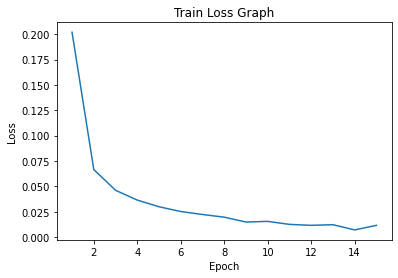

In [12]:
# Loss graph
plt.plot(range(1,epochs+1), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Graph')
plt.show()

Accuracy : 98.91%
Label:  4
Prediction:  4


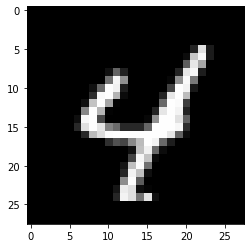

In [13]:
# 모델 성능 확인
with torch.no_grad(): # torch.no_grad(): gradient 계산을 수행하지 않음
  model.eval()
  accuracy = 0.0

  for iter, data in enumerate(test_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    pred = torch.argmax(output,1) == labels
    accuracy += pred.float().sum()
    
  print("Accuracy : {:.2f}%".format(100*accuracy/len(test_dataset)))

  # 테스트 데이터에서 무작위로 하나를 뽑아서 예측
  r = random.randint(0, len(test_dataset)-1)
  X_single_data = test_dataset.data[r].view(1, 1, 28, 28).float().to(device)
  Y_single_data = test_dataset.targets[r].to(device)

  print('Label: ', Y_single_data.item())
  single_prediction = model(X_single_data)
  print('Prediction: ', torch.argmax(single_prediction, 1).item())

  plt.imshow(test_dataset.data[r].view(28, 28), cmap='gray')
  plt.show()

In [15]:
# 모델 통째로 저장
torch.save(model,'cnn.pth')

In [14]:
# 모델의 weight만 저장
torch.save(model.state_dict(),'cnn_weight.pth')